In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

### Prepare data

In [29]:
class Vector(object):

    def __init__(self, start, end):
        self.start = start
        self.end = end
        self.centroid = (start + end) / 2
        
    def __sub__(self, other):
        return Vector(self.end, other.start)
    
    def intersects(self, other):
        # check if two vectors intersect
        return self.start <= other.end and other.start <= self.end
    
    def __len__(self):
        return self.end - self.start
    
    def __str__(self):
        return f'({self.start}, {self.end})'

#  define Distance functions
def iou(a:Vector, b: Vector):
    intersection = max(0, min(a.end, b.end) - max(a.start, b.start))
    union = len(a) + len(b) - intersection
    return intersection / union

def precision(a, b):
    true_positive = a==b
    false_positive = a!=b
    return true_positive / (true_positive + false_positive)

def recall(a, b):
    true_positive = a==b
    false_negative = a!=b
    return true_positive / (true_positive + false_negative)

def f1_score(a, b):
    p = precision(a, b)
    r = recall(a, b)
    return 2 * (p * r) / (p + r)

def iou_multiple(vas, vbs):
    return np.mean([iou(va, vb) for va in vas for vb in vbs])

def normalized_hamming_distance(label1, label2):
    differences = sum(1 for l1, l2 in zip(label1[1], label2[1]) if l1 != l2)
    hamming_distance = differences / len(label1)
    return hamming_distance

def normalized_ordinal_distance(ordinal1, ordinal2, max_value=3):
    ordinal_distance = abs(ordinal1 - ordinal2) / max_value
    return ordinal_distance

def normalized_ordinal_distance_multiple(ordinal1s, ordinal2s, max_value):
    return np.mean([normalized_ordinal_distance(o1, o2) for o1 in ordinal1s for o2 in ordinal2s])

def normalized_hamming_distance_multiple(labels1, labels2):
    return np.mean([normalized_hamming_distance(l1, l2) for l1 in labels1 for l2 in labels2])

def score(row1, row2, weights=(0.33, 0.33, 0.34)):
    # iou_score = iou(row1[0], row2[0])
    hamming_score = normalized_hamming_distance(row1[1], row2[1])
    ordinal_score = normalized_ordinal_distance(row1[2][0], row2[2][0], 3)
    return sum([hamming_score * weights[1], ordinal_score * weights[2]])

def score_multiple(row1, row2):
    return np.mean([score(r1, r2) for r1 in row1 for r2 in row2])


In [12]:
df = pd.read_csv('../datasets/fluencybank/our_annotations/reading/csv/total_label.csv')
df['timevr'] = df.apply(lambda row: Vector(row['start'], row['end']), axis=1)
df['annotations'] = df.apply(lambda row: [Vector(row['start'], row['end']), row['label']], axis=1)
df_ann = df[df['annotator'].isin(['A1', 'A2', 'A3'])]
df_gold = df[df['annotator'] == 'Gold']
df_ann.head()

,media_file,annotator,start,end,label,split,FP,SR,ISR,MUR,P,B,NV,V,FG,HM,ME,T,timevr,annotations
0,60m,A2,5800,6560,_;FG;1,train,0,0,0,0,0,0,0,0,1,0,0,1,"(5800, 6560)","[(5800, 6560), _;FG;1]"
1,60m,A2,9830,10380,_;HM;1,train,0,0,0,0,0,0,0,0,0,1,0,1,"(9830, 10380)","[(9830, 10380), _;HM;1]"
2,60m,A2,11100,11630,_;FG+HM;1,train,0,0,0,0,0,0,0,0,1,1,0,1,"(11100, 11630)","[(11100, 11630), _;FG+HM;1]"
3,60m,A2,17120,17460,_;FG+HM;1,train,0,0,0,0,0,0,0,0,1,1,0,1,"(17120, 17460)","[(17120, 17460), _;FG+HM;1]"
4,60m,A2,29220,31020,MUR;0;1,train,0,0,0,1,0,0,0,0,0,0,0,1,"(29220, 31020)","[(29220, 31020), MUR;0;1]"


In [20]:
#  Unionize the vector ranges in to similar groups

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import euclidean_distances
from collections import defaultdict
import copy

def unionize_vectorrange_sequence(vectorranges):
    min_s = min([vr.start for vr in vectorranges])
    max_e = max([vr.end for vr in vectorranges])
    return Vector(min_s, max_e)

def fragment_by_overlaps(annodf, uid_colname, item_colname, label_colname, decomp_fn, dist_fn=None, gold_df=None):
    resultdfs = []
    for item_id in annodf[item_colname].unique():
        idf = annodf[annodf[item_colname] == item_id]
        vectorranges = [vas[0] for vas in idf[label_colname]]

        regions = decomp_fn(vectorranges, dist_fn=dist_fn)
        origItemID = []
        newItemID = []
        newItemVR = []
        uid = []
        label = []
        timevr = []
        goldtimevr = []
        goldlabel = []
        for region in regions:
            for i, row in idf.iterrows():
                if region.intersects(row[label_colname][0]):
                    origItemID.append(item_id)
                    newItemID.append(F"{item_id}-{region}")
                    newItemVR.append(region)
                    uid.append(row[uid_colname])
                    label.append(row['label'])
                    timevr.append(row['timevr'])
                    if gold_df is not None:
                        # get the gold label that intersects with the region
                        gold_timevr = [vr[0] for vr in gold_df[(gold_df[item_colname] == item_id)][label_colname] if region.intersects(vr[0])]
                        gold_timevr = gold_timevr[0] if len(gold_timevr) > 0 else None
                        goldtimevr.append(gold_timevr)

                        gold_label = [lbl[1] for lbl in gold_df[(gold_df[item_colname] == item_id)][label_colname] if region.intersects(lbl[0])]
                        gold_label = gold_label[0] if len(gold_label) > 0 else None
                        goldlabel.append(gold_label)
                    else:
                        goldtimevr.append(None)
        resultdfs.append(pd.DataFrame({"origItemID":origItemID, "newItemID":newItemID, "newItemVR":newItemVR, uid_colname:uid, label_colname:label, "timevr":timevr, "goldTimeVR":goldtimevr, "gold":goldlabel}))
    return pd.concat(resultdfs)

def decomp_fn(vectorranges, use_centroids=True, dist_fn=None):

    if use_centroids:
        centroids = np.array([vr.centroid for vr in vectorranges]).reshape(-1, 1)
        # dists = euclidean_distances(centroids)
        # mean_dist = np.std(dists)
        mean_dist = 1000
        clustering = AgglomerativeClustering(n_clusters=None,
                                             distance_threshold=mean_dist)
        clustering.fit(centroids)
    else:
        dists = np.array([[1 - iou(a, b) for a in vectorranges] for b in vectorranges])
        mean_dist = np.std(dists)
        clustering = AgglomerativeClustering(n_clusters=None,
                                             distance_threshold=mean_dist,
                                             affinity="precomputed",
                                             linkage="average")
        clustering.fit(dists)
        
    labels = clustering.labels_
    labeldict = defaultdict(list)
    for i, label in enumerate(labels):
        labeldict[label].append(i)
    result = []
    for indices in labeldict.values():
        uv = unionize_vectorrange_sequence(np.array(vectorranges)[np.array(indices)])
        result.append(uv)

    return result

grannodf = fragment_by_overlaps(df_ann, "annotator", "media_file", "annotations", decomp_fn, gold_df=df_gold)
# grannodf['gold'] = grannodf['gold'].apply(lambda x: x[0] if len(x) > 0 else None)
grannodf.head()

,origItemID,newItemID,newItemVR,annotator,annotations,timevr,goldTimeVR,gold
0,60m,"60m-(5800, 6560)","(5800, 6560)",A2,_;FG;1,"(5800, 6560)",None,None
1,60m,"60m-(9830, 10380)","(9830, 10380)",A2,_;HM;1,"(9830, 10380)",None,None
2,60m,"60m-(11100, 11630)","(11100, 11630)",A2,_;FG+HM;1,"(11100, 11630)",None,None
3,60m,"60m-(17120, 17460)","(17120, 17460)",A2,_;FG+HM;1,"(17120, 17460)",None,None
4,60m,"60m-(29220, 31020)","(29220, 31020)",A2,MUR;0;1,"(29220, 31020)",None,None


In [21]:
grannodf[grannodf['gold'].notnull()]

,origItemID,newItemID,newItemVR,annotator,annotations,timevr,goldTimeVR,gold
0,50fb,"50fb-(1230, 8730)","(1230, 8730)",A2,_;V+FG;2,"(1230, 8490)","(1230, 8730)",B;FG;1
1,50fb,"50fb-(1230, 8730)","(1230, 8730)",A3,B;FG;1,"(1460, 8730)","(1230, 8730)",B;FG;1
2,50fb,"50fb-(10050, 10738)","(10050, 10738)",A2,P;HM;1,"(10050, 10550)","(10050, 10738)",P;HM;1
3,50fb,"50fb-(10050, 10738)","(10050, 10738)",A1,P;0;0,"(10096, 10738)","(10050, 10738)",P;HM;1
4,50fb,"50fb-(11710, 19850)","(11710, 19850)",A2,_;V+FG;2,"(12470, 19020)","(11710, 19850)",;V+FG;1
...,...,...,...,...,...,...,...,...
387,25m,"25m-(212893, 213149)","(212893, 213149)",A2,B+P;V+FG;3,"(211043, 213503)","(211020, 213503)",ISR+B;V+FG+HM;2
388,25m,"25m-(212893, 213149)","(212893, 213149)",A1,P;V+FG;1,"(212893, 213149)","(211020, 213503)",ISR+B;V+FG+HM;2
389,25m,"25m-(224403, 225340)","(224403, 225340)",A2,SR+B;FG;3,"(224420, 226760)","(224403, 225340)",ISR+B;V+FG;1
390,25m,"25m-(224403, 225340)","(224403, 225340)",A3,SR;HM;2,"(224390, 226720)","(224403, 225340)",ISR+B;V+FG;1


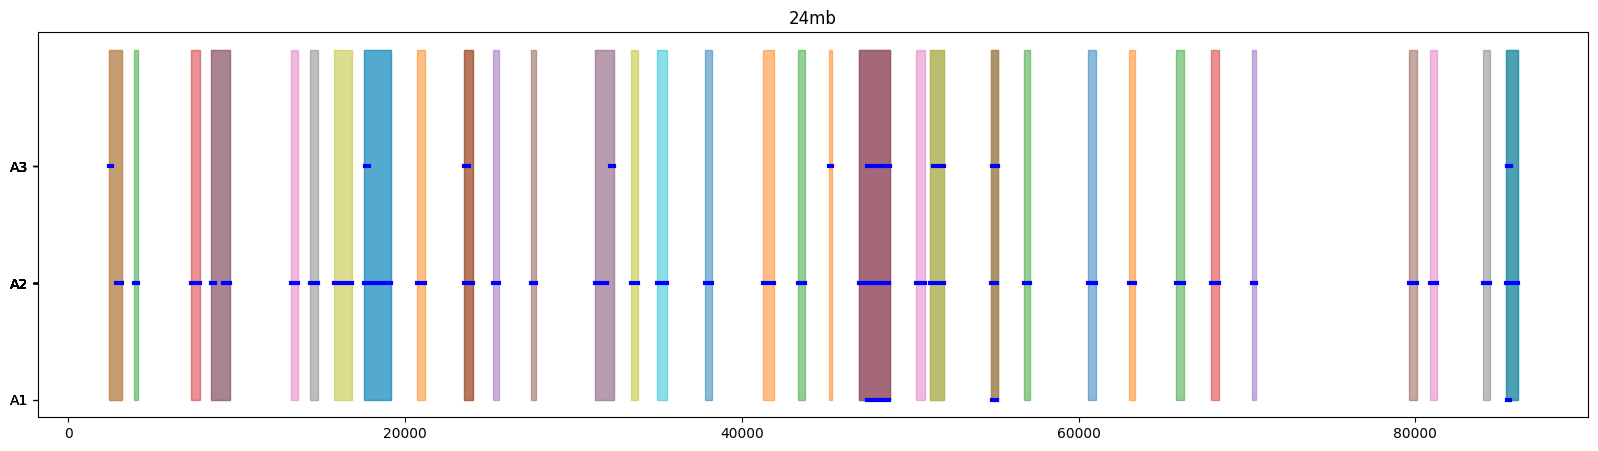

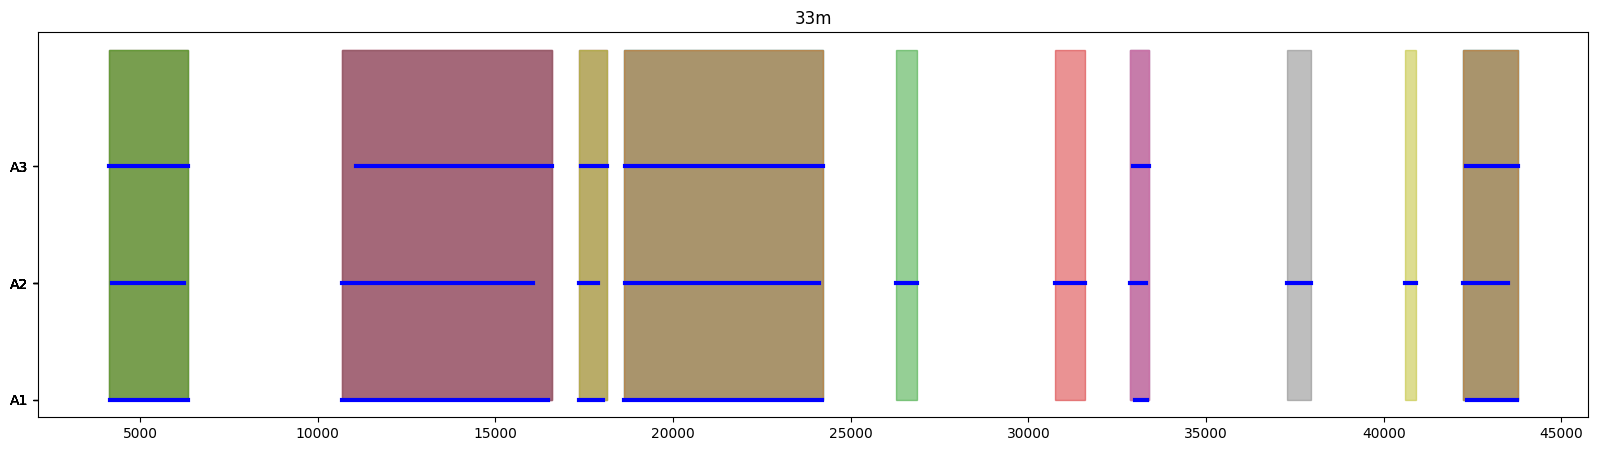

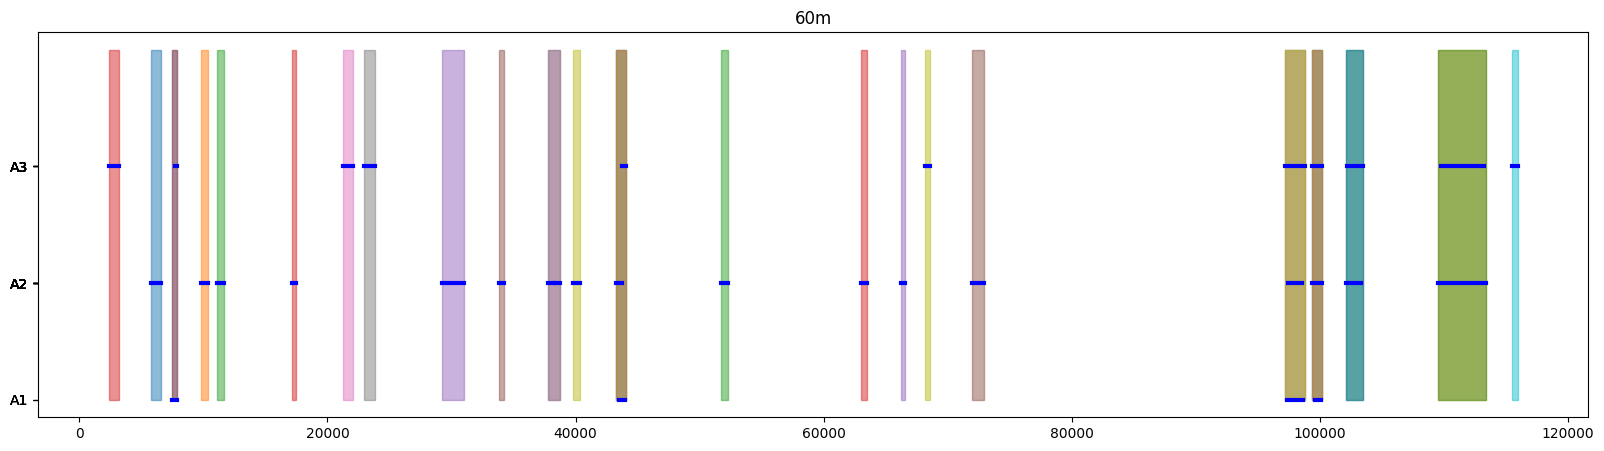

""


In [26]:
# visualize groupings
from matplotlib.patches import Rectangle
def plot_vectorranges(vr,y, color='b', linewidth=1, alpha=1):
    plt.plot([vr.start, vr.end], y, color=color, linewidth=linewidth, alpha=alpha)

def plot_ann(data):
    vrs = [va for va in data['timevr']]
    ys = [i for i in data['annotator_id']]
    unique_items = data['newItemID'].unique()

    # colors = sns.color_palette('tab10', n_colors=len(unique_items))

    fig, ax = plt.subplots(figsize=(20, 5))
    for vr, y in zip(vrs, ys):
        plot_vectorranges(vr, [y,y], linewidth=3)

    colors = sns.color_palette('tab10', n_colors=len(unique_items))
    # plot the groupings
    for i,vr in enumerate(data['newItemVR']):
        color = i % len(colors)
        ax.add_patch(Rectangle((vr.start, 0), len(vr), 3, alpha=0.5, color=colors[color]))
    # plot the gold annotation with dashed rectangle
    for i,vr in enumerate(data['gold']):
        if vr:
            ax.add_patch(Rectangle((vr[0].start, 0), len(vr[0]), 3, linestyle='--', facecolor='none', fill=None))

    plt.yticks(ys, data['annotator'])
    plt.title(data['origItemID'].values[0])
    plt.show()

grannodf['annotator_id'] = grannodf['annotator'].astype('category').cat.codes
# grannodf['timeVr'] = grannodf['annotations'].apply(lambda x: x[0])
grannodf.iloc[:100].groupby('origItemID').apply(plot_ann)

### Calculate the iaa using Time Span only 

#### On all A1, A2 and A3

In [28]:
grannodf.head()

,origItemID,newItemID,newItemVR,annotator,annotations,timevr,goldTimeVR,gold,annotator_id
0,60m,1245,"(5800, 6560)",A2,_;FG;1,"(5800, 6560)",None,None,1
1,60m,1252,"(9830, 10380)",A2,_;HM;1,"(9830, 10380)",None,None,1
2,60m,1233,"(11100, 11630)",A2,_;FG+HM;1,"(11100, 11630)",None,None,1
3,60m,1235,"(17120, 17460)",A2,_;FG+HM;1,"(17120, 17460)",None,None,1
4,60m,1239,"(29220, 31020)",A2,MUR;0;1,"(29220, 31020)",None,None,1


In [31]:
import sys
sys.path.append('../annotationmodeling')
from agreement import InterAnnotatorAgreement

grannodf['newItemID'] = grannodf['newItemID'].astype('category').cat.codes

def inv_iou(x, y):
    return 1 - iou(x, y)
iaa = InterAnnotatorAgreement(annodf=grannodf, distance_fn=inv_iou, label_colname="timevr", item_colname="newItemID", uid_colname="annotator_id")
iaa.setup()
print(f'Krippendorff alpha: {iaa.get_krippendorff_alpha()}')
print(f'Ks : {iaa.get_ks()}')
print(f'Sigma: {iaa.get_sigma()}')


Calculating same-item distances
Calculating different-item distances
Krippendorff alpha: 0.45582649894403526
Ks : 0.7724588125582841
Sigma: 0.776188995958968


In [12]:
# iaa.plot_distance_distributions()
# iaa.plot_matrix(show_grid=False)

#### Only between between A1 and A3

In [36]:
grannodf_temp =  grannodf.copy()
grannodf_temp = grannodf[grannodf['annotator'].isin(['A1', 'A3'])]
grannodf_temp = grannodf_temp[~grannodf_temp['origItemID'].isin(['24fc'])]
# grannodf_temp['anotator_id'] = grannodf_temp['annotator'].astype('category').cat.codes
iaa_temp = InterAnnotatorAgreement(annodf=grannodf_temp, distance_fn=inv_iou, label_colname="timevr", item_colname="newItemID", uid_colname="annotator_id")
iaa_temp.setup()
print(f'Krippendorff alpha: {iaa_temp.get_krippendorff_alpha()}')
print(f'Ks: {iaa_temp.get_ks()}')
print(f'Sigma: {iaa_temp.get_sigma()}')

Calculating same-item distances
Calculating different-item distances
Krippendorff alpha: 0.4380133271702016
Ks: 0.7256281407035176
Sigma: 0.7256281407035177


In [14]:
# iaa_temp.plot_distance_distributions()
# iaa_temp.plot_matrix(show_grid=False)

### Compute IAA per class

In [44]:
label_columns = ['SR','ISR','MUR','P','B', 'NV', 'V', 'FG', 'HM', 'ME']
from stutter.utils import LabelMap
label_map = LabelMap()
def get_class_Value(row, c):
    class_idx = label_map.labeltoidx[c]
    return label_map.labelfromstr(row)[class_idx]

def simple_distance(x, y):
    return 1 if x != y else 0
for c in label_columns:
    grannodf_temp =  grannodf.copy()
    grannodf_temp = grannodf[grannodf['annotator'].isin(['A1', 'A2', 'A3'])]
    grannodf_temp['annotator_id'] = grannodf_temp['annotator'].astype('category').cat.codes
    grannodf_temp[c] = grannodf_temp['annotations'].apply(lambda x:get_class_Value(x, c))
    iaa_temp = InterAnnotatorAgreement(annodf=grannodf_temp, distance_fn=simple_distance, label_colname=c, item_colname="newItemID", uid_colname="annotator_id")
    iaa_temp.setup()
    print(f'evaluating {c}')
    print(f'\tKrippendorff alpha: {iaa_temp.get_krippendorff_alpha()}')
    print(f'\tKs: {iaa_temp.get_ks()}')
    print(f'\tSigma: {iaa_temp.get_sigma()}')

Calculating same-item distances
Calculating different-item distances
evaluating SR
	Krippendorff alpha: 0.25730994152046793
	Ks: 0.06838669567920423
	Sigma: 0.8026111283804787
Calculating same-item distances
Calculating different-item distances
evaluating ISR
	Krippendorff alpha: 0.13138686131386867
	Ks: 0.0335716506061548
	Sigma: 0.77805408765931
Calculating same-item distances
Calculating different-item distances
evaluating MUR
	Krippendorff alpha: 0.2844036697247706
	Ks: 0.02890892135529997
	Sigma: 0.9272614236866645
Calculating same-item distances
Calculating different-item distances
evaluating P
	Krippendorff alpha: 0.5732546705998033
	Ks: 0.1812247435498912
	Sigma: 0.8650917003419335
Calculating same-item distances
Calculating different-item distances
evaluating B
	Krippendorff alpha: 0.4109195402298851
	Ks: 0.17780540876593098
	Sigma: 0.7451041342866025
Calculating same-item distances
Calculating different-item distances
evaluating NV
	Krippendorff alpha: 0.7142857142857143
	Ks:

In [13]:
def compute_fleiss_kappa(df, item_col, annotator_col, category_col):
    # Step 1: Group by item and category, and count the number of ratings per category for each item
    grouped = df.groupby([item_col, category_col]).size().unstack(fill_value=0)
    
    # Step 2: Convert the grouped DataFrame to a matrix
    matrix = grouped.values
    
    # Step 3: Compute Fleiss' Kappa
    N, k = matrix.shape  # N is the number of items, k is the number of categories
    n = np.sum(matrix[0])  # n is the number of raters per item

    # Calculate p_j
    p_j = np.sum(matrix, axis=0) / (N * n)

    # Calculate P_i
    P_i = (np.sum(matrix * (matrix - 1), axis=1) / (n * (n - 1)))

    # Calculate mean agreement over all items
    P_bar = np.mean(P_i)

    # Calculate expected agreement by chance
    P_e_bar = np.sum(p_j ** 2)

    # Calculate Fleiss' Kappa
    kappa = (P_bar - P_e_bar) / (1 - P_e_bar)
    return kappa

compute_fleiss_kappa(grannodf, 'newItemID', 'anotator', 'FP')

-1.527373252491237

### Calculating IAA over tention using using eucledian distance

In [46]:
grannodf.head()
def euclidean_distances(x, y):
    return np.linalg.norm(x - y)

grannodf_temp =  grannodf.copy()
grannodf_temp = grannodf[grannodf['annotator'].isin(['A1', 'A2', 'A3'])]
grannodf_temp['annotator_id'] = grannodf_temp['annotator'].astype('category').cat.codes
grannodf_temp['T'] = grannodf_temp['annotations'].apply(lambda x:get_class_Value(x, 'T'))
iaa_temp = InterAnnotatorAgreement(annodf=grannodf_temp, distance_fn=euclidean_distances, label_colname=c, item_colname="newItemID", uid_colname="annotator_id")
iaa_temp.setup()
print(f'evaluating T')
print(f'\tKrippendorff alpha: {iaa_temp.get_krippendorff_alpha()}')
print(f'\tKs: {iaa_temp.get_ks()}')
print(f'\tSigma: {iaa_temp.get_sigma()}')

Calculating same-item distances
Calculating different-item distances
evaluating T
	Krippendorff alpha: 0.17596281540504644
	Ks: 0.08983525023313646
	Sigma: 0.35965184954926954


In [53]:
df = pd.read_csv('../datasets/fluencybank/ds_5/reading/total_df.csv')
df = df[~df['annotator'].isin(['A1', 'A2', 'A3', 'Gold'])]
df.head()

,media_file,clip_id,clip_start,clip_end,annotator,start,end,FP,SR,ISR,MUR,P,B,NV,V,FG,HM,ME,T


In [82]:
def get_class_Value(x, c):
    if x is np.nan:
        return 0
    class_idx = label_map.labeltoidx[c]
    return label_map.labelfromstr(x)[class_idx]
temp_grannodf = grannodf.copy()
temp_grannodf = temp_grannodf[temp_grannodf['annotator'].isin(['A1', 'A3'])]
pivot_df = grannodf.pivot_table(index='newItemID', columns='annotator', values='annotations', aggfunc='first')
pivot_df[['A1', 'A3']] = pivot_df[['A1', 'A3']].applymap(lambda x: get_class_Value(x, 'B'))
pivot_df.values
def compute_fleiss_kappa(matrix):
    N, n = matrix.shape  # N is the number of items, n is the number of annotators

    # Transform the matrix to count the number of annotators who assigned each category (0 or 1) to each item
    transformed_matrix = np.zeros((N, 2), dtype=int)
    for i in range(N):
        transformed_matrix[i, 0] = np.sum(matrix[i] == 0)
        transformed_matrix[i, 1] = np.sum(matrix[i] == 1)
    print(transformed_matrix.shape, [np.max(transformed_matrix, axis=1)<2])
    # Calculate p_j (proportion of all assignments to each category)
    p_j = np.sum(transformed_matrix, axis=0) / (N * n)
    P_i = (np.sum(transformed_matrix * (transformed_matrix - 1), axis=1) / (n * (n - 1)))
    P_bar = np.mean(P_i)
    P_e_bar = np.sum(p_j ** 2)
    kappa = (P_bar - P_e_bar) / (1 - P_e_bar)
    return kappa

compute_fleiss_kappa(pivot_df.values)

(1281, 2) [False False False ... False False False]


-0.05075112785542596

In [17]:
import sys
sys.path.append('../annotationmodeling')
from agreement import InterAnnotatorAgreement

grannodf['newItemID'] = grannodf['newItemID'].astype('category').cat.codes

def inv_score(x, y):
    return score(x, y)

iaa = InterAnnotatorAgreement(annodf=grannodf, distance_fn=normalized_hamming_distance, label_colname="annotations", item_colname="newItemID", uid_colname="anotator_id")
iaa.setup()
print(f'Krippendorff alpha: {iaa.get_krippendorff_alpha()}')
print(f'Ks : {iaa.get_ks()}')
print(f'Sigma: {iaa.get_sigma()}')


Calculating same-item distances
Calculating different-item distances
Krippendorff alpha: 0.16325301204819276
Ks : 0.15063829787234043
Sigma: 0.07829787234042551


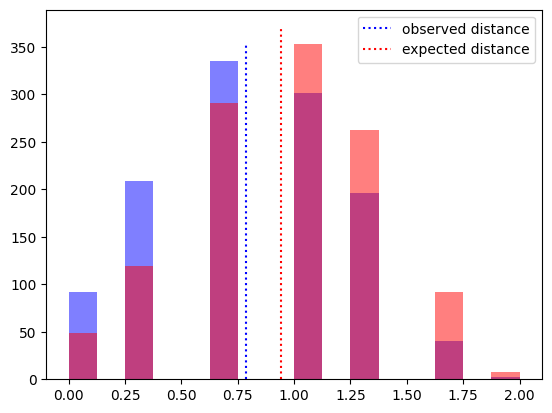

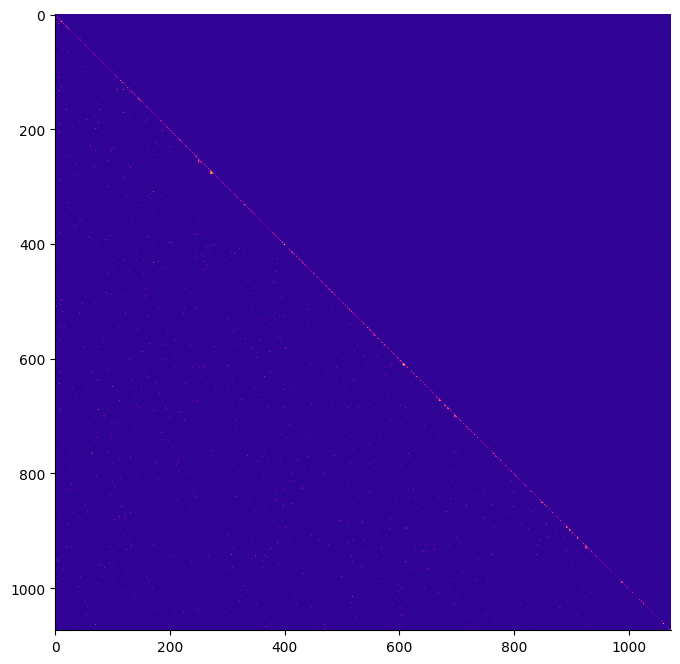

In [18]:
iaa.plot_distance_distributions()
iaa.plot_matrix(show_grid=False)

## Aggregation

In [19]:
import sys
sys.path.append("../annotationmodeling")
from experiments import RealExperiment
df = pd.read_csv('../datasets/fluencybank/csv/test/reading_test.csv')
iaa_exp = RealExperiment(eval_fn=iou,label_colname="timeVr",
                                                    item_colname="newItemID", uid_colname="anotator")
iaa_exp.setup(grannodf, golddf=grannodf, c_gold_item="newItemID", c_gold_label="timeVr")
iaa_exp.train(iter=0, masX_iter=0)
# iaa_exp.test(debug=False)

100%|██████████| 406/406 [00:00<00:00, 697.62it/s]
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f2f75b1a490cf818851956f5849af989 NOW.


Pickled model not found
Compiling model
../annotationmodeling/stan_files/dem_semisup


cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
In file included from /fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /tmp/pystan_i4ez8nz5/stanfit4anon_model_f2f75b1a490cf818851956f5849af989_1825764970189437361.cpp:1315:
/fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with "

Pickling model
Initial log joint probability = -159.675
Pickled model not found
Compiling model
../annotationmodeling/stan_files/mas2_semisup
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       4      -129.724      0.655215       59.5054           1           1        5   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       9      -25.8313       4.87492       69.9972           1           1       11   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      14      0.699887      0.631751       32.7641      0.9814      0.9814       16   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       9.06505     0.0800172       5.88311           1           1       21   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      24       12.7877      0.523908       4.65873

DIAGNOSTIC(S) FROM PARSER:
Info: Comments beginning with # are deprecated.  Please use // in place of # for line comments.
Info: Comments beginning with # are deprecated.  Please use // in place of # for line comments.

cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
In file included from /fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /tmp/pystan_o6k4dlcy/stanfit4anon_model_0a42423d6797de0c623e8873b9455595_7792309906962712306.cpp:1315:
/fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy

Pickling model
Initial log joint probability = -11271.3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       4      -3479.58      0.303421       76.6706      0.5128           1        8   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       9      -3415.16       1.54246       348.124           1           1       13   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      14      -1451.59       7.56925       1233.07        0.81        0.81       20   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -18.2578       1.05674       216.903      0.8187      0.8187       26   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      24       2244.52       2.71171       1363.02      0.5115      0.5115       33   
    Iter      log prob        ||dx||      ||grad|

In [23]:
iaa_exp.bau_preds

{0: <__main__.Vector at 0x7f11f6430700>,
 1: <__main__.Vector at 0x7f11f64308e0>,
 2: <__main__.Vector at 0x7f11f649ae80>,
 3: <__main__.Vector at 0x7f11f6430ac0>,
 4: <__main__.Vector at 0x7f11f6430ca0>,
 5: <__main__.Vector at 0x7f11f64350a0>,
 6: <__main__.Vector at 0x7f11f64a0640>,
 7: <__main__.Vector at 0x7f11f6435460>,
 8: <__main__.Vector at 0x7f11f6435820>,
 9: <__main__.Vector at 0x7f11f6435a00>,
 10: <__main__.Vector at 0x7f11f64a0820>,
 11: <__main__.Vector at 0x7f11f6435be0>,
 12: <__main__.Vector at 0x7f11f6435dc0>,
 13: <__main__.Vector at 0x7f11f6435fa0>,
 14: <__main__.Vector at 0x7f11f64391c0>,
 15: <__main__.Vector at 0x7f11f64393a0>,
 16: <__main__.Vector at 0x7f11f6439580>,
 17: <__main__.Vector at 0x7f11f64a0a00>,
 18: <__main__.Vector at 0x7f11f6439760>,
 19: <__main__.Vector at 0x7f11f6439b20>,
 20: <__main__.Vector at 0x7f11f6439d00>,
 21: <__main__.Vector at 0x7f11f6439ee0>,
 22: <__main__.Vector at 0x7f11f643e100>,
 23: <__main__.Vector at 0x7f11f643e2e0>,
 2